In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG
from db import Result
import papermill as pm
import os
import seaborn
import pandas
import matplotlib.pyplot as plt
from collections import defaultdict 
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import cohen_kappa_score
from evaluate import calculate_confusion_matrix_stats_predictions, calculate_roc_curve, roc_auc_score
from scipy.stats import binom_test, fisher_exact, chi2_contingency
from tabulate import tabulate
from calculate_features import all_features
from config import config
from data_gen import data
plt.rcParams['svg.fonttype'] = 'none'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SKIP = False
UUIDS = [    
     "bb203f76-fc98-44ed-a8e6-2592c681457e", # t2, outcome_pos
     "ec0a84dd-313b-44fc-9110-d72a62ee12a2", # t1, outcome_pos
     #"7e946fc2-5f5d-46b8-94e6-c57ea02f32ad", # t2, outcome_neg
     #"ba0de65e-7e2b-483f-b2ec-f41a39959e6d" # t1, outcome_neg
     #"55fc2831-93df-4314-92d8-cfcedb2be91a", # t2, outcome_3
     #"0edc5931-1fd4-4f3a-b296-f97fd308f299", # t1, outcome_3
]
SELECTIONS = {
     "bb203f76-fc98-44ed-a8e6-2592c681457e": None, #t2, outcome_pos
     "ec0a84dd-313b-44fc-9110-d72a62ee12a2": None, # t1, outcome_pos
     #"7e946fc2-5f5d-46b8-94e6-c57ea02f32ad": None, # t2, outcome_neg
     #"ba0de65e-7e2b-483f-b2ec-f41a39959e6d": None, # t1, outcome_neg
     #"55fc2831-93df-4314-92d8-cfcedb2be91a": None, # t2, outcome_3
     #"0edc5931-1fd4-4f3a-b296-f97fd308f299": None, # t1, outcome_3
}
TSNE_PERPLEXITY = {
    "bb203f76-fc98-44ed-a8e6-2592c681457e": 10, # t2, outcome_pos
    "ec0a84dd-313b-44fc-9110-d72a62ee12a2": 10, # t1, outcome_pos
    #"7e946fc2-5f5d-46b8-94e6-c57ea02f32ad": 10, # t2, outcome_neg
    #"ba0de65e-7e2b-483f-b2ec-f41a39959e6d": 10, # t1, outcome_neg
    #"55fc2831-93df-4314-92d8-cfcedb2be91a": 10, # t2, outcome_3
    #"0edc5931-1fd4-4f3a-b296-f97fd308f299": 10, # t1, outcome_3
}
MODALITY = {
    "bb203f76-fc98-44ed-a8e6-2592c681457e": "t2", # t2, outcome_pos
    "ec0a84dd-313b-44fc-9110-d72a62ee12a2": "t1" # t1, outcome_pos
    #"7e946fc2-5f5d-46b8-94e6-c57ea02f32ad": "t2", # t2, outcome_neg
    #"ba0de65e-7e2b-483f-b2ec-f41a39959e6d": "t1", # t1, outcome_neg
    #"55fc2831-93df-4314-92d8-cfcedb2be91a": "t2", # t2, outcome_3
    #"0edc5931-1fd4-4f3a-b296-f97fd308f299": "t1", # t1, outcome_3
}

In [3]:
import math
def adjusted_wald(p, n, z=1.96):
    p_adj = (n * p + (z**2)/2)/(n+z**2)
    n_adj = n + z**2
    span = z * math.sqrt(p_adj*(1-p_adj)/n_adj)
    return max(0, p_adj - span), min(p_adj + span, 1.0)

In [4]:
def execute_notebook(uuid, selections=None, tsne_perplexity=5, input_form="none", description=""): 
    name = "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid)
    if not SKIP and not os.path.exists(name): 
        pm.execute_notebook(
            "evaluate-specific-model.ipynb",
            "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid),
            parameters = dict(
                UUID=uuid,
                SELECTIONS=repr(selections),
                TSNE_PERPLEXITY=tsne_perplexity,
            ),
    )
    return name

In [5]:
completed_notebooks = list()
modality_by_notebook = dict()

In [6]:
for uuid in UUIDS: 
    print(uuid)
    result = Result.query.filter(Result.uuid == uuid).first()
    name = execute_notebook(uuid, SELECTIONS.get(uuid), TSNE_PERPLEXITY.get(uuid), result.input_form, result.description)
    completed_notebooks.append(name)
    modality_by_notebook[name] = MODALITY[uuid]
    print("done")

bb203f76-fc98-44ed-a8e6-2592c681457e
done
ec0a84dd-313b-44fc-9110-d72a62ee12a2
done


In [7]:
modality_by_notebook

{'notebooks/evaluate-t1-t2-verified_trial1-t2-bb203f76-fc98-44ed-a8e6-2592c681457e.ipynb': 't2',
 'notebooks/evaluate-t1-t2-verified_trial1-t1-ec0a84dd-313b-44fc-9110-d72a62ee12a2.ipynb': 't1'}

In [8]:
if not SKIP and not os.path.exists(name): 
    name = "notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS))
    pm.execute_notebook(
        "evaluate-ensemble.ipynb",
        "notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)),
        parameters = dict(
            MODELS=UUIDS,
            SCORE="accuracy",
        ),
    )
completed_notebooks.append("notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)))

In [9]:
modality_by_notebook["notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS))] = "ensemble"

In [10]:
def get_notebook_output(notebook, name): 
    return (notebook.dataframe[notebook.dataframe.name==name].value.tolist())[0]

In [11]:
train = dict()
validation = dict()
test = dict()
test_1 = dict()
test_2 = dict()
for notebook in completed_notebooks: 
    nb = pm.read_notebook(notebook)
    train["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "train_labels")
    train["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "train_predictions")
    train["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "train_probabilities")
    validation["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "validation_labels")
    validation["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "validation_predictions")
    validation["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "validation_probabilities")
    test["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test_labels")
    test["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test_predictions")
    test["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test_probabilities")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-1_labels")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-1_predictions")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-1_probabilities")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-2_labels")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-2_predictions")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-2_probabilities")    

In [13]:
print(len(test['t1-predictions']))

{'t2-labels': [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0], 't2-predictions': [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0], 't2-probabilities': [0.8641476631164551, 0.04850572347640991, 0.7620673179626465, 0.58588045835495, 0.6092981696128845, 0.6122311949729919, 0.12623029947280884, 0.7747927904129028, 0.15856879949569702, 0.06381136178970337, 0.9023292660713196, 0.16890358924865723, 0.8298861980438232, 0.8764317631721497, 0.8906347751617432, 0.8994308114051819, 0.7904530763626099, 0.1235

In [29]:
completed_notebooks

['evaluate-t1-t2-verified_trial1-t2-bb203f76-fc98-44ed-a8e6-2592c681457e.ipynb',
 'evaluate-t1-t2-verified_trial1-t1-ec0a84dd-313b-44fc-9110-d72a62ee12a2.ipynb',
 'evaluate-ensemble-bb203f76-fc98-44ed-a8e6-2592c681457e-ec0a84dd-313b-44fc-9110-d72a62ee12a2.ipynb',
 'evaluate-ensemble-bb203f76-fc98-44ed-a8e6-2592c681457e-ec0a84dd-313b-44fc-9110-d72a62ee12a2.ipynb']

In [18]:
import uuid
result = Result.query.filter(Result.uuid == UUIDS[0]).first()
print(result.uuid)
print(result.split_seed)
train_set, validation_set, test_set = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

  0%|          | 0/622 [00:00<?, ?it/s]

bb203f76-fc98-44ed-a8e6-2592c681457e
84a64c17-fe3e-440c-aaaf-e1bd5b02576f
1072
889
Training points = 622
Benign: 349, Intermediate: 273, Malignant: 0

Validation points = 168
Benign: 96, Intermediate: 72, Malignant: 0

Testing points = 99
Benign: 54, Intermediate: 45, Malignant: 0
bone-china-046
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 1/622 [00:00<02:20,  4.43it/s]

bone-penn-157
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 3/622 [00:00<02:17,  4.49it/s]

bone-china-124
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-107
Does this patient have T2 available? True
I'm doing the thing.


  1%|          | 4/622 [00:01<03:06,  3.32it/s]

bone-hup-134
Does this patient have T2 available? True
I'm doing the thing.


  1%|          | 6/622 [00:01<02:44,  3.74it/s]

bone-china-068
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-522
Does this patient have T2 available? True
I'm doing the thing.


  1%|          | 7/622 [00:01<02:49,  3.62it/s]

bone-penn-279
Does this patient have T2 available? True
I'm doing the thing.


  1%|▏         | 8/622 [00:02<04:14,  2.41it/s]

bone-penn-81
Does this patient have T2 available? True
I'm doing the thing.
bone-china-128
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 10/622 [00:02<03:20,  3.05it/s]

bone-hup-296
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 13/622 [00:03<02:25,  4.18it/s]

bone-china-106
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-292
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-123
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 14/622 [00:03<02:21,  4.30it/s]

bone-penn-362
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 15/622 [00:03<02:33,  3.95it/s]

bone-penn-588
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 16/622 [00:04<02:45,  3.66it/s]

bone-penn-139
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 19/622 [00:04<02:03,  4.90it/s]

bone-penn-381
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-93
Does this patient have T2 available? True
I'm doing the thing.
bone-china-052
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 21/622 [00:04<01:47,  5.59it/s]

bone-penn-142
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-280
Does this patient have T2 available? True
I'm doing the thing.


  4%|▎         | 23/622 [00:05<01:40,  5.93it/s]

bone-penn-457
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-155
Does this patient have T2 available? True
I'm doing the thing.


  4%|▍         | 25/622 [00:05<01:36,  6.20it/s]

bone-hup-48
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-85
Does this patient have T2 available? True
I'm doing the thing.


  4%|▍         | 27/622 [00:05<01:23,  7.11it/s]

bone-penn-551
Does this patient have T2 available? True
I'm doing the thing.
bone-china-020
Does this patient have T2 available? True
I'm doing the thing.
bone-china-057
Does this patient have T2 available? True
I'm doing the thing.


  5%|▍         | 30/622 [00:06<01:22,  7.14it/s]

bone-china-107
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-105
Does this patient have T2 available? True
I'm doing the thing.


  5%|▍         | 31/622 [00:06<01:40,  5.90it/s]

bone-penn-106
Does this patient have T2 available? True
I'm doing the thing.


  5%|▌         | 33/622 [00:06<01:36,  6.10it/s]

bone-penn-94
Does this patient have T2 available? True
I'm doing the thing.
bone-china-089
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-303
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 36/622 [00:07<01:53,  5.18it/s]

bone-china-081
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-51
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 37/622 [00:07<01:48,  5.41it/s]

bone-penn-277
Does this patient have T2 available? True
I'm doing the thing.


  6%|▋         | 39/622 [00:08<02:12,  4.39it/s]

bone-penn-473
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-468
Does this patient have T2 available? True
I'm doing the thing.


  6%|▋         | 40/622 [00:09<04:46,  2.03it/s]

bone-china-069
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-478
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 43/622 [00:09<03:00,  3.21it/s]

bone-penn-495
Does this patient have T2 available? True
I'm doing the thing.
bone-china-040
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-148
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 45/622 [00:09<02:22,  4.04it/s]

bone-penn-481
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-330
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 48/622 [00:10<01:55,  4.95it/s]

bone-china-151
Does this patient have T2 available? True
I'm doing the thing.
bone-china-146
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 49/622 [00:10<01:45,  5.44it/s]

bone-china-056
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-038
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 52/622 [00:10<01:27,  6.55it/s]

bone-china-169
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-151
Does this patient have T2 available? True
I'm doing the thing.


  9%|▊         | 53/622 [00:11<03:03,  3.11it/s]

bone-hup-317
Does this patient have T2 available? True
I'm doing the thing.


  9%|▊         | 54/622 [00:11<02:58,  3.17it/s]

bone-penn-047
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 56/622 [00:12<03:25,  2.75it/s]

bone-hup-151
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-118
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 58/622 [00:14<04:52,  1.93it/s]

bone-china-114
Does this patient have T2 available? True
I'm doing the thing.
bone-china-062
Does this patient have T2 available? True
I'm doing the thing.


 10%|▉         | 60/622 [00:14<03:02,  3.08it/s]

bone-china-163
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-90
Does this patient have T2 available? True
I'm doing the thing.


 10%|▉         | 61/622 [00:14<02:27,  3.80it/s]

bone-penn-497
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-265
Does this patient have T2 available? True
I'm doing the thing.


 10%|█         | 65/622 [00:15<01:42,  5.41it/s]

bone-china-162
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-104
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-485
Does this patient have T2 available? True
I'm doing the thing.


 11%|█         | 66/622 [00:15<02:14,  4.13it/s]

bone-china-004
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-131
Does this patient have T2 available? True
I'm doing the thing.


 11%|█         | 68/622 [00:15<01:53,  4.88it/s]

bone-penn-577
Does this patient have T2 available? True
I'm doing the thing.


 11%|█▏        | 71/622 [00:16<01:38,  5.58it/s]

bone-china-077
Does this patient have T2 available? True
I'm doing the thing.
bone-china-032
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-152
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 72/622 [00:16<01:42,  5.36it/s]

bone-penn-84
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 74/622 [00:16<01:43,  5.27it/s]

bone-china-120
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-074
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 75/622 [00:17<01:44,  5.25it/s]

bone-penn-143
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 77/622 [00:17<01:47,  5.07it/s]

bone-hup-124
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-474
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 79/622 [00:17<01:31,  5.95it/s]

bone-penn-530
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-115
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 81/622 [00:18<01:19,  6.77it/s]

bone-penn-384
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-322
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 82/622 [00:18<01:15,  7.17it/s]

bone-china-055
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-585
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▎        | 85/622 [00:18<01:15,  7.14it/s]

bone-china-148
Does this patient have T2 available? True
I'm doing the thing.
bone-china-149
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 86/622 [00:18<01:17,  6.96it/s]

bone-penn-005
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 88/622 [00:19<01:44,  5.10it/s]

bone-china-031
Does this patient have T2 available? True
I'm doing the thing.
bone-china-033
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 89/622 [00:19<01:29,  5.97it/s]

bone-penn-032
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▍        | 91/622 [00:19<01:52,  4.73it/s]

bone-penn-001
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-529
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▍        | 93/622 [00:20<01:49,  4.83it/s]

bone-penn-492
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-587
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▌        | 94/622 [00:20<01:59,  4.41it/s]

bone-china-053
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-127
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▌        | 96/622 [00:20<01:45,  4.96it/s]

bone-hup-297
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 97/622 [00:21<02:51,  3.05it/s]

bone-hup-290
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 100/622 [00:21<02:11,  3.98it/s]

bone-china-166
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-95
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-110
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 101/622 [00:22<02:14,  3.88it/s]

bone-hup-305
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▋        | 102/622 [00:22<02:27,  3.51it/s]

bone-china-072
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-532
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 105/622 [00:22<01:49,  4.70it/s]

bone-china-139
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-274
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 107/622 [00:23<02:27,  3.49it/s]

bone-china-101
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-299
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 109/622 [00:24<02:05,  4.09it/s]

bone-hup-309
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-490
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 111/622 [00:24<02:23,  3.56it/s]

bone-penn-140
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-3
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 112/622 [00:25<02:27,  3.46it/s]

bone-china-109
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-278
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 114/622 [00:25<02:10,  3.88it/s]

bone-penn-134
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▊        | 116/622 [00:26<02:14,  3.75it/s]

bone-china-160
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-067
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-550
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 119/622 [00:26<01:48,  4.65it/s]

bone-china-112
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-487
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 121/622 [00:27<02:23,  3.48it/s]

bone-hup-278
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-435
Does this patient have T2 available? True
I'm doing the thing.


 20%|█▉        | 122/622 [00:27<02:02,  4.10it/s]

bone-penn-496
Does this patient have T2 available? True
I'm doing the thing.


 20%|█▉        | 124/622 [00:28<02:31,  3.28it/s]

bone-china-026
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-347
Does this patient have T2 available? True
I'm doing the thing.


 20%|██        | 125/622 [00:28<02:25,  3.42it/s]

bone-penn-535
Does this patient have T2 available? True
I'm doing the thing.


 20%|██        | 127/622 [00:29<02:13,  3.72it/s]

bone-china-070
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-027
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 128/622 [00:29<02:46,  2.97it/s]

bone-penn-112
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 130/622 [00:31<04:22,  1.87it/s]

bone-china-117
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-509
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-518
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 132/622 [00:31<03:35,  2.27it/s]

bone-penn-553
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 134/622 [00:32<02:40,  3.05it/s]

bone-china-110
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-595
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 136/622 [00:32<02:03,  3.95it/s]

bone-china-140
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-070
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 138/622 [00:33<02:51,  2.83it/s]

bone-china-010
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-147
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 140/622 [00:34<03:00,  2.68it/s]

bone-china-044
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-296
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 142/622 [00:35<02:19,  3.44it/s]

bone-penn-541
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-565
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 143/622 [00:35<02:36,  3.05it/s]

bone-china-060
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-369
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 145/622 [00:35<02:06,  3.78it/s]

bone-penn-150
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▎       | 147/622 [00:36<01:55,  4.11it/s]

bone-china-168
Does this patient have T2 available? True
I'm doing the thing.
bone-china-144
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-321
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 150/622 [00:36<01:41,  4.64it/s]

bone-china-037
Does this patient have T2 available? True
I'm doing the thing.
bone-china-009
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 152/622 [00:37<01:25,  5.51it/s]

bone-hup-293
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-028
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▍       | 154/622 [00:37<01:19,  5.88it/s]

bone-china-085
Does this patient have T2 available? True
I'm doing the thing.
bone-china-115
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▌       | 156/622 [00:37<01:11,  6.54it/s]

bone-penn-317
Does this patient have T2 available? True
I'm doing the thing.
bone-china-103
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▌       | 158/622 [00:37<01:01,  7.53it/s]

bone-china-034
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-146
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-152
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 160/622 [00:38<01:06,  6.90it/s]

bone-penn-275
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-275
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 163/622 [00:39<01:28,  5.16it/s]

bone-china-100
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-042
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▋       | 164/622 [00:39<01:24,  5.45it/s]

bone-china-154
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-96
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 167/622 [00:40<01:31,  4.96it/s]

bone-penn-527
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-004
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 168/622 [00:40<01:48,  4.18it/s]

bone-penn-108
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 170/622 [00:41<01:53,  4.00it/s]

bone-china-035
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-051
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 171/622 [00:41<01:41,  4.43it/s]

bone-penn-612
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 172/622 [00:41<02:15,  3.31it/s]

bone-penn-502
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 173/622 [00:42<02:54,  2.57it/s]

bone-penn-97
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 175/622 [00:43<02:49,  2.64it/s]

bone-china-073
Does this patient have T2 available? True
I'm doing the thing.
bone-china-173
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 177/622 [00:43<02:08,  3.46it/s]

bone-penn-549
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-349
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▊       | 178/622 [00:43<01:51,  3.98it/s]

bone-penn-456
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▉       | 179/622 [00:43<02:12,  3.35it/s]

bone-hup-267
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▉       | 181/622 [00:44<01:43,  4.25it/s]

bone-china-135
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-291
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▉       | 182/622 [00:44<01:29,  4.94it/s]

bone-penn-575
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▉       | 183/622 [00:44<01:42,  4.27it/s]

bone-hup-276
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-99
Does this patient have T2 available? True
I'm doing the thing.


 30%|██▉       | 185/622 [00:45<01:38,  4.45it/s]

bone-penn-568
Does this patient have T2 available? True
I'm doing the thing.


 30%|███       | 187/622 [00:45<01:25,  5.07it/s]

bone-china-041
Does this patient have T2 available? True
I'm doing the thing.
bone-china-029
Does this patient have T2 available? True
I'm doing the thing.
bone-china-158
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 190/622 [00:45<01:03,  6.79it/s]

bone-china-132
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-119
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 191/622 [00:45<01:03,  6.78it/s]

bone-hup-154
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 192/622 [00:46<01:16,  5.64it/s]

bone-penn-571
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 194/622 [00:46<01:25,  5.03it/s]

bone-penn-413
Does this patient have T2 available? True
I'm doing the thing.
bone-china-092
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 196/622 [00:46<01:14,  5.68it/s]

bone-china-086
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-304
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 198/622 [00:47<01:01,  6.86it/s]

bone-china-119
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-286
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 200/622 [00:47<00:57,  7.31it/s]

bone-china-126
Does this patient have T2 available? True
I'm doing the thing.
bone-china-045
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 202/622 [00:47<00:54,  7.78it/s]

bone-penn-320
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-501
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-480
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 206/622 [00:47<00:47,  8.74it/s]

bone-penn-154
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-141
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-401
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 208/622 [00:48<01:02,  6.65it/s]

bone-china-091
Does this patient have T2 available? True
I'm doing the thing.
bone-china-134
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▍      | 211/622 [00:48<00:48,  8.41it/s]

bone-penn-348
Does this patient have T2 available? True
I'm doing the thing.
bone-china-116
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-488
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-556
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▍      | 214/622 [00:49<00:58,  7.00it/s]

bone-china-147
Does this patient have T2 available? True
I'm doing the thing.
bone-china-066
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▍      | 216/622 [00:49<00:55,  7.38it/s]

bone-china-075
Does this patient have T2 available? True
I'm doing the thing.
bone-china-074
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▍      | 217/622 [00:49<00:59,  6.76it/s]

bone-penn-101
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▌      | 219/622 [00:49<01:11,  5.64it/s]

bone-penn-057
Does this patient have T2 available? True
I'm doing the thing.
bone-china-123
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 221/622 [00:50<01:07,  5.91it/s]

bone-penn-459
Does this patient have T2 available? True
I'm doing the thing.
bone-china-006
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 222/622 [00:50<01:04,  6.23it/s]

bone-penn-334
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 224/622 [00:51<01:30,  4.42it/s]

bone-china-016
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-516
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 225/622 [00:51<01:46,  3.74it/s]

bone-penn-062
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▋      | 226/622 [00:52<03:15,  2.03it/s]

bone-hup-266
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 228/622 [00:52<02:22,  2.77it/s]

bone-penn-471
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-593
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 230/622 [00:53<01:49,  3.57it/s]

bone-china-022
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-303
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 232/622 [00:53<01:16,  5.08it/s]

bone-china-083
Does this patient have T2 available? True
I'm doing the thing.
bone-china-099
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-528
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 235/622 [00:53<01:04,  6.01it/s]

bone-penn-149
Does this patient have T2 available? True
I'm doing the thing.
bone-china-121
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 237/622 [00:53<00:59,  6.46it/s]

bone-penn-159
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-274
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 238/622 [00:54<00:56,  6.74it/s]

bone-hup-328
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▊      | 240/622 [00:54<01:18,  4.87it/s]

bone-hup-142
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-87
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▉      | 242/622 [00:55<01:14,  5.07it/s]

bone-china-071
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-592
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-498
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▉      | 244/622 [00:55<01:02,  6.00it/s]

bone-china-088
Does this patient have T2 available? True
I'm doing the thing.


 40%|███▉      | 246/622 [00:55<01:03,  5.93it/s]

bone-china-042
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-129
Does this patient have T2 available? True
I'm doing the thing.


 40%|███▉      | 248/622 [00:56<01:35,  3.93it/s]

bone-china-153
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-137
Does this patient have T2 available? True
I'm doing the thing.


 40%|████      | 249/622 [00:56<01:45,  3.54it/s]

bone-penn-508
Does this patient have T2 available? True
I'm doing the thing.


 40%|████      | 250/622 [00:57<01:42,  3.63it/s]

bone-penn-538
Does this patient have T2 available? True
I'm doing the thing.


 40%|████      | 251/622 [00:57<02:00,  3.07it/s]

bone-china-014
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-589
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 253/622 [00:57<01:43,  3.56it/s]

bone-penn-446
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 255/622 [00:58<01:21,  4.51it/s]

bone-china-080
Does this patient have T2 available? True
I'm doing the thing.
bone-china-087
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-111
Does this patient have T2 available? True
I'm doing the thing.


 41%|████▏     | 258/622 [00:58<01:05,  5.56it/s]

bone-hup-330
Does this patient have T2 available? True
I'm doing the thing.
bone-china-131
Does this patient have T2 available? True
I'm doing the thing.
bone-china-143
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 261/622 [00:59<00:58,  6.20it/s]

bone-china-104
Does this patient have T2 available? True
I'm doing the thing.
bone-china-155
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 263/622 [00:59<00:50,  7.13it/s]

bone-penn-504
Does this patient have T2 available? True
I'm doing the thing.
bone-china-027
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 265/622 [00:59<00:43,  8.14it/s]

bone-hup-257
Does this patient have T2 available? True
I'm doing the thing.
bone-china-129
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-045
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 268/622 [00:59<00:47,  7.45it/s]

bone-china-084
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-327
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 269/622 [00:59<00:45,  7.80it/s]

bone-penn-313
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▎     | 271/622 [01:00<01:01,  5.74it/s]

bone-hup-292
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-506
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▍     | 274/622 [01:00<00:58,  5.92it/s]

bone-penn-586
Does this patient have T2 available? True
I'm doing the thing.
bone-china-138
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-161
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▍     | 276/622 [01:01<00:48,  7.14it/s]

bone-hup-310
Does this patient have T2 available? True
I'm doing the thing.
bone-china-017
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-382
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▍     | 278/622 [01:01<00:42,  8.02it/s]

bone-hup-122
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-126
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▌     | 282/622 [01:01<00:43,  7.84it/s]

bone-hup-298
Does this patient have T2 available? True
I'm doing the thing.
bone-china-049
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-306
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▌     | 283/622 [01:01<00:49,  6.82it/s]

bone-hup-295
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 284/622 [01:02<01:38,  3.43it/s]

bone-penn-289
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 285/622 [01:02<01:39,  3.39it/s]

bone-china-059
Does this patient have T2 available? True
I'm doing the thing.
bone-china-118
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 287/622 [01:03<01:22,  4.08it/s]

bone-hup-158
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▋     | 289/622 [01:03<01:14,  4.45it/s]

bone-china-001
Does this patient have T2 available? True
I'm doing the thing.
bone-china-047
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 290/622 [01:03<01:03,  5.21it/s]

bone-china-054
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-058
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 292/622 [01:04<01:14,  4.44it/s]

bone-china-021
Does this patient have T2 available? True
I'm doing the thing.
bone-china-076
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 295/622 [01:04<01:07,  4.84it/s]

bone-hup-150
Does this patient have T2 available? True
I'm doing the thing.
bone-china-136
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 297/622 [01:05<00:55,  5.86it/s]

bone-penn-015
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-312
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 299/622 [01:05<00:55,  5.78it/s]

bone-penn-548
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-056
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 300/622 [01:05<01:10,  4.58it/s]

bone-penn-453
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▊     | 302/622 [01:06<01:10,  4.53it/s]

bone-china-015
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-271
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▉     | 304/622 [01:06<01:05,  4.84it/s]

bone-penn-071
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-555
Does this patient have T2 available? True
I'm doing the thing.


 50%|████▉     | 308/622 [01:07<00:53,  5.88it/s]

bone-penn-403
Does this patient have T2 available? True
I'm doing the thing.
bone-china-061
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-537
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-503
Does this patient have T2 available? True
I'm doing the thing.


 50%|████▉     | 309/622 [01:07<00:49,  6.28it/s]

bone-china-152
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-322
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 311/622 [01:07<00:49,  6.24it/s]

bone-china-002
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-462
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 314/622 [01:08<00:50,  6.12it/s]

bone-hup-315
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-116
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████     | 315/622 [01:08<00:46,  6.63it/s]

bone-penn-86
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████     | 317/622 [01:08<00:59,  5.15it/s]

bone-china-170
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-291
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████     | 318/622 [01:08<00:52,  5.80it/s]

bone-china-058
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████▏    | 319/622 [01:09<01:57,  2.58it/s]

bone-hup-299
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████▏    | 320/622 [01:09<01:41,  2.99it/s]

bone-penn-452
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 321/622 [01:10<01:42,  2.94it/s]

bone-hup-314
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-578
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 323/622 [01:11<02:00,  2.49it/s]

bone-penn-131
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 324/622 [01:11<01:55,  2.58it/s]

bone-penn-037
Does this patient have T2 available? True
I'm doing the thing.
bone-china-122
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 327/622 [01:12<01:15,  3.89it/s]

bone-penn-281
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-272
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 328/622 [01:12<01:30,  3.24it/s]

bone-china-161
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-385
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 330/622 [01:12<01:23,  3.48it/s]

bone-penn-591
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 331/622 [01:13<01:23,  3.48it/s]

bone-hup-281
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▎    | 333/622 [01:13<01:10,  4.13it/s]

bone-penn-061
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-91
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-397
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 335/622 [01:13<01:03,  4.55it/s]

bone-penn-521
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 337/622 [01:14<01:31,  3.13it/s]

bone-china-038
Does this patient have T2 available? True
I'm doing the thing.
bone-china-030
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-002
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▍    | 340/622 [01:15<01:04,  4.39it/s]

bone-china-065
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-572
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▍    | 341/622 [01:15<00:56,  5.02it/s]

bone-hup-302
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▌    | 343/622 [01:16<01:02,  4.45it/s]

bone-penn-491
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-423
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▌    | 344/622 [01:16<01:47,  2.58it/s]

bone-hup-320
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▌    | 345/622 [01:17<02:24,  1.92it/s]

bone-penn-500
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 346/622 [01:17<02:06,  2.18it/s]

bone-china-036
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-484
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 349/622 [01:18<01:16,  3.57it/s]

bone-china-175
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-030
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▋    | 351/622 [01:18<01:01,  4.43it/s]

bone-hup-79
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-175
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 352/622 [01:18<00:54,  4.96it/s]

bone-penn-226
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-011
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 355/622 [01:19<00:44,  6.00it/s]

bone-penn-188
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-166
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 356/622 [01:19<00:42,  6.32it/s]

bone-penn-239
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 357/622 [01:19<00:48,  5.43it/s]

bone-hup-101
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 358/622 [01:19<00:55,  4.73it/s]

bone-penn-311
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 360/622 [01:20<00:52,  4.96it/s]

bone-penn-161
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-628
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 362/622 [01:20<00:41,  6.29it/s]

bone-penn-180
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-599
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 363/622 [01:20<00:57,  4.52it/s]

bone-china-195
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-88
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▊    | 365/622 [01:21<00:59,  4.33it/s]

bone-penn-264
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 366/622 [01:21<01:07,  3.79it/s]

bone-penn-615
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 368/622 [01:22<01:03,  4.01it/s]

bone-china-203
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-98
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 370/622 [01:22<00:53,  4.71it/s]

bone-hup-73
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-641
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-378
Does this patient have T2 available? True
I'm doing the thing.


 60%|██████    | 374/622 [01:23<00:44,  5.63it/s]

bone-hup-113
Does this patient have T2 available? True
I'm doing the thing.
bone-china-228
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-206
Does this patient have T2 available? True
I'm doing the thing.


 60%|██████    | 376/622 [01:23<00:40,  6.10it/s]

bone-penn-651
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-80
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 377/622 [01:23<00:51,  4.74it/s]

bone-hup-141
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 378/622 [01:24<01:27,  2.80it/s]

bone-penn-429
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 380/622 [01:24<01:08,  3.53it/s]

bone-penn-370
Does this patient have T2 available? True
I'm doing the thing.
bone-china-186
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-277
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 384/622 [01:25<00:45,  5.25it/s]

bone-penn-165
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-283
Does this patient have T2 available? True
I'm doing the thing.
bone-china-200
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 386/622 [01:25<00:38,  6.06it/s]

bone-penn-298
Does this patient have T2 available? True
I'm doing the thing.
bone-china-204
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 387/622 [01:25<00:36,  6.41it/s]

bone-penn-263
Does this patient have T2 available? True
I'm doing the thing.


 63%|██████▎   | 389/622 [01:26<00:47,  4.86it/s]

bone-penn-193
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-211
Does this patient have T2 available? True
I'm doing the thing.


 63%|██████▎   | 391/622 [01:26<00:48,  4.79it/s]

bone-china-196
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-024
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-148
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▎   | 395/622 [01:27<00:36,  6.27it/s]

bone-penn-256
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-222
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-189
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▎   | 396/622 [01:28<01:15,  3.00it/s]

bone-hup-201
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▍   | 398/622 [01:28<01:02,  3.57it/s]

bone-penn-629
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-422
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▍   | 399/622 [01:28<00:59,  3.72it/s]

bone-penn-029
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▍   | 400/622 [01:29<01:17,  2.86it/s]

bone-penn-624
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▍   | 402/622 [01:29<00:57,  3.80it/s]

bone-hup-133
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-222
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▍   | 404/622 [01:29<00:44,  4.95it/s]

bone-china-188
Does this patient have T2 available? True
I'm doing the thing.
bone-china-210
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▌   | 405/622 [01:30<00:38,  5.61it/s]

bone-penn-514
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▌   | 406/622 [01:30<00:43,  4.99it/s]

bone-penn-167
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▌   | 407/622 [01:30<00:49,  4.38it/s]

bone-penn-637
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 408/622 [01:30<00:48,  4.39it/s]

bone-hup-97
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 410/622 [01:31<00:39,  5.37it/s]

bone-penn-640
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-103
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 411/622 [01:31<00:34,  6.15it/s]

bone-hup-22
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 412/622 [01:31<00:38,  5.38it/s]

bone-hup-246
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 414/622 [01:31<00:38,  5.35it/s]

bone-china-223
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-82
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 416/622 [01:32<00:36,  5.61it/s]

bone-hup-153
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-200
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-234
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 418/622 [01:32<00:33,  6.12it/s]

bone-penn-255
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 420/622 [01:32<00:35,  5.72it/s]

bone-penn-631
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-639
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 421/622 [01:33<00:37,  5.33it/s]

bone-hup-84
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 422/622 [01:33<01:03,  3.15it/s]

bone-penn-621
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 423/622 [01:34<01:30,  2.21it/s]

bone-penn-645
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 424/622 [01:34<01:26,  2.30it/s]

bone-hup-86
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 426/622 [01:35<01:20,  2.43it/s]

bone-china-187
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-85
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 428/622 [01:36<01:09,  2.77it/s]

bone-penn-183
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-466
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 429/622 [01:37<01:23,  2.31it/s]

bone-hup-96
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 430/622 [01:37<01:10,  2.71it/s]

bone-china-180
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 431/622 [01:37<01:08,  2.79it/s]

bone-penn-224
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-109
Does this patient have T2 available? True
I'm doing the thing.


 70%|██████▉   | 434/622 [01:38<00:52,  3.58it/s]

bone-hup-168
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-022
Does this patient have T2 available? True
I'm doing the thing.


 70%|███████   | 436/622 [01:38<00:41,  4.45it/s]

bone-penn-511
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-234
Does this patient have T2 available? True
I'm doing the thing.


 70%|███████   | 437/622 [01:39<01:01,  3.01it/s]

bone-penn-364
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████   | 439/622 [01:39<00:50,  3.60it/s]

bone-penn-616
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-214
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████   | 441/622 [01:39<00:41,  4.32it/s]

bone-penn-163
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-205
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████   | 443/622 [01:40<00:40,  4.37it/s]

bone-hup-192
Does this patient have T2 available? True
I'm doing the thing.
bone-china-215
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████▏  | 444/622 [01:40<00:35,  5.08it/s]

bone-penn-356
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 445/622 [01:41<00:56,  3.14it/s]

bone-hup-261
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 446/622 [01:42<01:34,  1.87it/s]

bone-hup-89
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 447/622 [01:42<01:23,  2.09it/s]

bone-penn-617
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 449/622 [01:43<01:14,  2.33it/s]

bone-china-234
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-388
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 451/622 [01:43<00:56,  3.04it/s]

bone-penn-633
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-380
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 452/622 [01:43<00:52,  3.26it/s]

bone-penn-261
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-118
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 454/622 [01:44<00:46,  3.60it/s]

bone-hup-224
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-213
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 456/622 [01:44<00:37,  4.42it/s]

bone-penn-241
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 457/622 [01:45<00:56,  2.90it/s]

bone-penn-646
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▎  | 458/622 [01:45<00:52,  3.10it/s]

bone-penn-203
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 459/622 [01:45<01:04,  2.52it/s]

bone-hup-193
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-166
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 461/622 [01:46<00:50,  3.20it/s]

bone-penn-611
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 462/622 [01:46<00:46,  3.46it/s]

bone-penn-178
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 463/622 [01:46<00:47,  3.38it/s]

bone-penn-627
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▍  | 464/622 [01:47<01:09,  2.27it/s]

bone-hup-54
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▍  | 465/622 [01:47<00:59,  2.65it/s]

bone-penn-171
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▍  | 466/622 [01:47<00:51,  3.00it/s]

bone-hup-226
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▌  | 468/622 [01:48<00:38,  3.96it/s]

bone-penn-198
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-2
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 470/622 [01:49<00:57,  2.66it/s]

bone-hup-67
Does this patient have T2 available? True
I'm doing the thing.
bone-china-177
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 471/622 [01:49<00:45,  3.34it/s]

bone-hup-39
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 474/622 [01:49<00:34,  4.35it/s]

bone-penn-531
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-77
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-006
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 476/622 [01:50<00:27,  5.25it/s]

bone-penn-266
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-601
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 477/622 [01:51<01:01,  2.37it/s]

bone-penn-363
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 480/622 [01:51<00:46,  3.05it/s]

bone-penn-414
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-56
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-83
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-169
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 483/622 [01:52<00:35,  3.96it/s]

bone-penn-620
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-94
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 484/622 [01:52<00:30,  4.51it/s]

bone-penn-124
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 485/622 [01:53<00:48,  2.84it/s]

bone-hup-232
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 487/622 [01:53<00:44,  3.05it/s]

bone-penn-014
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-314
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 488/622 [01:54<00:48,  2.74it/s]

bone-penn-644
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▊  | 489/622 [01:54<00:58,  2.28it/s]

bone-penn-194
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 491/622 [01:55<00:54,  2.42it/s]

bone-penn-608
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-179
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 492/622 [01:56<00:54,  2.40it/s]

bone-penn-238
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 494/622 [01:56<00:38,  3.36it/s]

bone-penn-460
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-102
Does this patient have T2 available? True
I'm doing the thing.


 80%|███████▉  | 495/622 [01:56<00:31,  3.98it/s]

bone-penn-622
Does this patient have T2 available? True
I'm doing the thing.


 80%|███████▉  | 497/622 [01:57<00:27,  4.53it/s]

bone-hup-144
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-171
Does this patient have T2 available? True
I'm doing the thing.


 80%|████████  | 499/622 [01:57<00:22,  5.47it/s]

bone-china-176
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-607
Does this patient have T2 available? True
I'm doing the thing.


 80%|████████  | 500/622 [01:58<00:37,  3.25it/s]

bone-penn-439
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 501/622 [01:58<00:46,  2.58it/s]

bone-penn-020
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-111
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 504/622 [01:59<00:33,  3.51it/s]

bone-penn-596
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-367
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████▏ | 506/622 [01:59<00:25,  4.48it/s]

bone-hup-55
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-316
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 507/622 [01:59<00:23,  4.90it/s]

bone-penn-458
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 508/622 [02:00<00:31,  3.58it/s]

bone-hup-211
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 510/622 [02:00<00:27,  4.07it/s]

bone-penn-268
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-026
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 511/622 [02:00<00:24,  4.53it/s]

bone-penn-010
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 512/622 [02:01<00:26,  4.20it/s]

bone-penn-191
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 513/622 [02:01<00:27,  3.94it/s]

bone-penn-052
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 514/622 [02:01<00:30,  3.56it/s]

bone-hup-160
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 516/622 [02:02<00:29,  3.57it/s]

bone-penn-073
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-368
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-479
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 519/622 [02:02<00:22,  4.66it/s]

bone-penn-172
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-063
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 521/622 [02:02<00:16,  6.23it/s]

bone-penn-119
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-069
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 524/622 [02:03<00:13,  7.09it/s]

bone-china-209
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-300
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-273
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▍ | 526/622 [02:03<00:14,  6.50it/s]

bone-hup-65
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-259
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-169
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▌ | 529/622 [02:04<00:14,  6.48it/s]

bone-hup-61
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-309
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▌ | 531/622 [02:04<00:15,  5.94it/s]

bone-penn-650
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-614
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▌ | 533/622 [02:04<00:14,  5.94it/s]

bone-penn-405
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-600
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▌ | 534/622 [02:04<00:14,  6.14it/s]

bone-hup-81
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-626
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-52
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▋ | 537/622 [02:05<00:14,  5.88it/s]

bone-hup-93
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▋ | 538/622 [02:06<00:24,  3.37it/s]

bone-hup-23
Does this patient have T2 available? True
I'm doing the thing.


 87%|████████▋ | 539/622 [02:06<00:33,  2.47it/s]

bone-penn-643
Does this patient have T2 available? True
I'm doing the thing.


 87%|████████▋ | 540/622 [02:07<00:32,  2.51it/s]

bone-hup-237
Does this patient have T2 available? True
I'm doing the thing.


 87%|████████▋ | 542/622 [02:07<00:22,  3.62it/s]

bone-china-231
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-598
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 545/622 [02:07<00:16,  4.53it/s]

bone-hup-179
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-244
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 547/622 [02:08<00:14,  5.08it/s]

bone-hup-138
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-244
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-219
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 549/622 [02:08<00:11,  6.15it/s]

bone-hup-262
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-055
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 550/622 [02:08<00:12,  5.84it/s]

bone-penn-192
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▊ | 551/622 [02:08<00:14,  4.94it/s]

bone-penn-236
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▊ | 552/622 [02:09<00:17,  4.01it/s]

bone-penn-018
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 553/622 [02:09<00:23,  2.97it/s]

bone-penn-072
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 554/622 [02:10<00:23,  2.85it/s]

bone-penn-546
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 555/622 [02:10<00:21,  3.09it/s]

bone-china-201
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-597
Does this patient have T2 available? True
I'm doing the thing.


 90%|████████▉ | 558/622 [02:11<00:20,  3.06it/s]

bone-hup-91
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-227
Does this patient have T2 available? True
I'm doing the thing.


 90%|█████████ | 560/622 [02:13<00:27,  2.26it/s]

bone-penn-464
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-467
Does this patient have T2 available? True
I'm doing the thing.


 90%|█████████ | 562/622 [02:13<00:17,  3.45it/s]

bone-hup-228
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-618
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 564/622 [02:13<00:14,  3.98it/s]

bone-penn-253
Does this patient have T2 available? True
I'm doing the thing.
bone-china-198
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 565/622 [02:13<00:11,  4.83it/s]

bone-penn-223
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 566/622 [02:14<00:18,  2.98it/s]

bone-hup-112
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 567/622 [02:14<00:17,  3.21it/s]

bone-hup-105
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-62
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████▏| 569/622 [02:15<00:13,  3.87it/s]

bone-china-199
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-126
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 572/622 [02:15<00:10,  4.60it/s]

bone-penn-064
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-461
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 574/622 [02:16<00:12,  3.76it/s]

bone-penn-606
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-265
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 577/622 [02:16<00:09,  4.69it/s]

bone-hup-225
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-60
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-279
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 579/622 [02:17<00:07,  5.53it/s]

bone-hup-53
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-196
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 581/622 [02:17<00:06,  6.16it/s]

bone-penn-254
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-079
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-602
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 584/622 [02:17<00:06,  5.69it/s]

bone-penn-652
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-70
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 586/622 [02:18<00:05,  6.30it/s]

bone-china-212
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-386
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 587/622 [02:18<00:08,  4.23it/s]

bone-china-243
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▍| 589/622 [02:19<00:07,  4.50it/s]

bone-penn-174
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-170
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▌| 591/622 [02:19<00:05,  5.43it/s]

bone-penn-647
Does this patient have T2 available? True
I'm doing the thing.
bone-china-194
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▌| 592/622 [02:19<00:05,  5.96it/s]

bone-penn-610
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▌| 593/622 [02:19<00:05,  5.15it/s]

bone-penn-372
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 596/622 [02:20<00:04,  5.75it/s]

bone-penn-176
Does this patient have T2 available? True
I'm doing the thing.
bone-china-190
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-636
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 598/622 [02:20<00:04,  5.97it/s]

bone-hup-110
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-041
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 601/622 [02:21<00:04,  4.96it/s]

bone-china-184
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-207
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-248
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 603/622 [02:21<00:03,  5.90it/s]

bone-hup-183
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-180
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 604/622 [02:21<00:03,  5.75it/s]

bone-penn-418
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 605/622 [02:22<00:05,  3.35it/s]

bone-hup-106
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 606/622 [02:22<00:05,  3.09it/s]

bone-penn-247
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-191
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 609/622 [02:22<00:03,  4.15it/s]

bone-hup-231
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-160
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 611/622 [02:23<00:02,  4.95it/s]

bone-penn-653
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-231
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 612/622 [02:23<00:03,  3.25it/s]

bone-penn-246
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-214
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▊| 614/622 [02:24<00:02,  3.72it/s]

bone-china-222
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-69
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▉| 617/622 [02:24<00:01,  4.95it/s]

bone-china-221
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-390
Does this patient have T2 available? True
I'm doing the thing.


100%|█████████▉| 619/622 [02:24<00:00,  5.32it/s]

bone-china-193
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-263
Does this patient have T2 available? True
I'm doing the thing.


100%|█████████▉| 621/622 [02:25<00:00,  6.00it/s]

bone-penn-168
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-217
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 0/168 [00:00<?, ?it/s]

bone-penn-113
Does this patient have T2 available? True
I'm doing the thing.
bone-china-003
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 3/168 [00:00<00:22,  7.21it/s]

bone-penn-630
Does this patient have T2 available? True
I'm doing the thing.
bone-china-078
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 4/168 [00:00<00:21,  7.53it/s]

bone-hup-326
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 5/168 [00:01<00:45,  3.62it/s]

bone-penn-054
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-312
Does this patient have T2 available? True
I'm doing the thing.


  4%|▍         | 7/168 [00:01<00:45,  3.55it/s]

bone-hup-116
Does this patient have T2 available? True
I'm doing the thing.


  5%|▍         | 8/168 [00:02<00:47,  3.36it/s]

bone-penn-031
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-482
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 10/168 [00:02<00:52,  3.03it/s]

bone-penn-82
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 11/168 [00:03<00:49,  3.18it/s]

bone-china-165
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-583
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 14/168 [00:03<00:35,  4.34it/s]

bone-china-145
Does this patient have T2 available? True
I'm doing the thing.
bone-china-079
Does this patient have T2 available? True
I'm doing the thing.


 10%|▉         | 16/168 [00:03<00:28,  5.42it/s]

bone-hup-287
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-328
Does this patient have T2 available? True
I'm doing the thing.


 10%|█         | 17/168 [00:03<00:24,  6.23it/s]

bone-hup-128
Does this patient have T2 available? True
I'm doing the thing.


 11%|█         | 18/168 [00:04<00:32,  4.63it/s]

bone-penn-283
Does this patient have T2 available? True
I'm doing the thing.


 11%|█▏        | 19/168 [00:04<00:34,  4.33it/s]

bone-penn-576
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 20/168 [00:04<00:38,  3.80it/s]

bone-penn-392
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 22/168 [00:05<00:37,  3.93it/s]

bone-penn-454
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-374
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 24/168 [00:05<00:33,  4.35it/s]

bone-china-127
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-147
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▌        | 26/168 [00:06<00:32,  4.32it/s]

bone-hup-301
Does this patient have T2 available? True
I'm doing the thing.
bone-china-174
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 27/168 [00:06<00:35,  4.02it/s]

bone-hup-316
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 28/168 [00:06<00:35,  3.93it/s]

bone-china-025
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-285
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 32/168 [00:07<00:27,  4.98it/s]

bone-penn-512
Does this patient have T2 available? True
I'm doing the thing.
bone-china-171
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-325
Does this patient have T2 available? True
I'm doing the thing.


 20%|█▉        | 33/168 [00:07<00:30,  4.49it/s]

bone-penn-517
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 35/168 [00:08<00:26,  5.03it/s]

bone-china-105
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-109
Does this patient have T2 available? True
I'm doing the thing.


 21%|██▏       | 36/168 [00:08<00:22,  5.81it/s]

bone-china-125
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-016
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 39/168 [00:08<00:21,  6.14it/s]

bone-china-028
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-136
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 40/168 [00:09<00:19,  6.55it/s]

bone-penn-83
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▌       | 42/168 [00:09<00:21,  5.79it/s]

bone-penn-130
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-017
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 44/168 [00:09<00:18,  6.68it/s]

bone-penn-346
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-489
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 47/168 [00:10<00:20,  5.80it/s]

bone-china-167
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-417
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-156
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▉       | 49/168 [00:10<00:20,  5.91it/s]

bone-penn-590
Does this patient have T2 available? True
I'm doing the thing.
bone-china-051
Does this patient have T2 available? True
I'm doing the thing.


 30%|███       | 51/168 [00:10<00:16,  6.95it/s]

bone-penn-98
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-077
Does this patient have T2 available? True
I'm doing the thing.
bone-china-050
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 53/168 [00:10<00:13,  8.22it/s]

bone-penn-494
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-542
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 55/168 [00:11<00:22,  5.12it/s]

bone-penn-049
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 56/168 [00:11<00:24,  4.59it/s]

bone-penn-536
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▍      | 58/168 [00:12<00:26,  4.13it/s]

bone-penn-564
Does this patient have T2 available? True
I'm doing the thing.
bone-china-113
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 60/168 [00:12<00:19,  5.40it/s]

bone-penn-613
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-455
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 62/168 [00:13<00:22,  4.79it/s]

bone-penn-520
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-155
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 63/168 [00:13<00:20,  5.11it/s]

bone-penn-068
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-332
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▊      | 65/168 [00:13<00:19,  5.26it/s]

bone-penn-007
Does this patient have T2 available? True
I'm doing the thing.


 40%|███▉      | 67/168 [00:14<00:19,  5.19it/s]

bone-penn-561
Does this patient have T2 available? True
I'm doing the thing.
bone-china-005
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-039
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 70/168 [00:14<00:15,  6.30it/s]

bone-china-039
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-396
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 71/168 [00:14<00:25,  3.80it/s]

bone-penn-329
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▍     | 74/168 [00:15<00:26,  3.51it/s]

bone-penn-319
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-282
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-329
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 77/168 [00:16<00:22,  4.01it/s]

bone-penn-476
Does this patient have T2 available? True
I'm doing the thing.
bone-china-159
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-139
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 79/168 [00:16<00:17,  5.04it/s]

bone-hup-307
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-297
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 80/168 [00:16<00:16,  5.32it/s]

bone-china-133
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-132
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▉     | 83/168 [00:17<00:16,  5.10it/s]

bone-penn-375
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-391
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 84/168 [00:17<00:14,  5.91it/s]

bone-penn-040
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████     | 86/168 [00:17<00:16,  5.08it/s]

bone-china-093
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-293
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 87/168 [00:18<00:13,  5.81it/s]

bone-penn-515
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 89/168 [00:18<00:16,  4.85it/s]

bone-china-164
Does this patient have T2 available? True
I'm doing the thing.
bone-china-019
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-157
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▍    | 92/168 [00:19<00:18,  4.16it/s]

bone-penn-078
Does this patient have T2 available? True
I'm doing the thing.
bone-china-043
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 94/168 [00:19<00:15,  4.91it/s]

bone-hup-145
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-579
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 96/168 [00:20<00:12,  5.65it/s]

bone-hup-308
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-059
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 98/168 [00:20<00:15,  4.38it/s]

bone-hup-229
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-204
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-044
Does this patient have T2 available? True
I'm doing the thing.


 60%|██████    | 101/168 [00:21<00:15,  4.40it/s]

bone-penn-245
Does this patient have T2 available? True
I'm doing the thing.
bone-china-242
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 102/168 [00:21<00:14,  4.40it/s]

bone-penn-260
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 104/168 [00:22<00:15,  4.06it/s]

bone-china-225
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-048
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▎   | 105/168 [00:22<00:24,  2.61it/s]

bone-penn-603
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▎   | 107/168 [00:23<00:17,  3.57it/s]

bone-penn-632
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-203
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▌   | 110/168 [00:23<00:10,  5.45it/s]

bone-china-211
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-379
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-609
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 111/168 [00:24<00:19,  2.95it/s]

bone-hup-188
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 112/168 [00:24<00:20,  2.70it/s]

bone-penn-065
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 114/168 [00:25<00:23,  2.27it/s]

bone-china-226
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-120
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 115/168 [00:26<00:19,  2.73it/s]

bone-penn-433
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 116/168 [00:26<00:24,  2.12it/s]

bone-hup-76
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-190
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████   | 119/168 [00:27<00:15,  3.17it/s]

bone-penn-197
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-104
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 121/168 [00:27<00:11,  4.09it/s]

bone-penn-220
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-122
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 122/168 [00:27<00:09,  4.63it/s]

bone-penn-019
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-219
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 124/168 [00:28<00:08,  5.29it/s]

bone-hup-108
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-013
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 127/168 [00:28<00:08,  4.79it/s]

bone-hup-132
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-269
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 129/168 [00:28<00:06,  6.12it/s]

bone-penn-021
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-035
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-232
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▊  | 132/168 [00:29<00:05,  6.76it/s]

bone-hup-227
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-95
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 133/168 [00:29<00:04,  7.37it/s]

bone-penn-465
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 136/168 [00:30<00:06,  5.06it/s]

bone-china-216
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-605
Does this patient have T2 available? True
I'm doing the thing.
bone-china-217
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 138/168 [00:30<00:05,  5.91it/s]

bone-penn-200
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-053
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 139/168 [00:30<00:04,  5.99it/s]

bone-penn-205
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 140/168 [00:32<00:17,  1.63it/s]

bone-china-179
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-463
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▌ | 143/168 [00:32<00:09,  2.72it/s]

bone-penn-187
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-59
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▋ | 145/168 [00:32<00:06,  3.55it/s]

bone-penn-258
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-648
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 147/168 [00:33<00:04,  4.44it/s]

bone-china-192
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-216
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▊ | 149/168 [00:33<00:03,  4.86it/s]

bone-penn-181
Does this patient have T2 available? True
I'm doing the thing.
bone-china-213
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 150/168 [00:33<00:03,  5.53it/s]

bone-hup-78
Does this patient have T2 available? True
I'm doing the thing.


 90%|████████▉ | 151/168 [00:33<00:03,  5.27it/s]

bone-hup-156
Does this patient have T2 available? True
I'm doing the thing.


 90%|█████████ | 152/168 [00:34<00:04,  3.51it/s]

bone-penn-075
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 153/168 [00:34<00:04,  3.27it/s]

bone-penn-654
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-182
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 156/168 [00:35<00:02,  4.25it/s]

bone-penn-173
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-207
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 158/168 [00:35<00:02,  4.41it/s]

bone-hup-181
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-177
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▌| 160/168 [00:35<00:01,  5.00it/s]

bone-hup-72
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-173
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 161/168 [00:36<00:02,  3.12it/s]

bone-hup-92
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▋| 162/168 [00:36<00:01,  3.20it/s]

bone-penn-034
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 163/168 [00:38<00:03,  1.48it/s]

bone-penn-307
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 165/168 [00:38<00:01,  2.21it/s]

bone-penn-210
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-305
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▉| 166/168 [00:39<00:00,  2.69it/s]

bone-penn-218
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 0/99 [00:00<?, ?it/s]

bone-china-189
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-137
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 2/99 [00:00<00:11,  8.09it/s]

bone-hup-130
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-120
Does this patient have T2 available? True
I'm doing the thing.


  5%|▌         | 5/99 [00:00<00:12,  7.76it/s]

bone-hup-143
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-127
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-295
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 7/99 [00:00<00:10,  8.46it/s]

bone-penn-594
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-582
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 9/99 [00:00<00:10,  8.90it/s]

bone-penn-574
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-125
Does this patient have T2 available? True
I'm doing the thing.


 10%|█         | 10/99 [00:01<00:12,  7.36it/s]

bone-penn-407
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 12/99 [00:01<00:15,  5.75it/s]

bone-penn-432
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-117
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 13/99 [00:01<00:13,  6.55it/s]

bone-penn-393
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-389
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▌        | 15/99 [00:02<00:16,  5.24it/s]

bone-penn-387
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 16/99 [00:02<00:23,  3.55it/s]

bone-penn-229
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 17/99 [00:03<00:25,  3.26it/s]

bone-hup-174
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 18/99 [00:03<00:35,  2.30it/s]

bone-hup-190
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 19/99 [00:04<00:33,  2.37it/s]

bone-hup-238
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-164
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 23/99 [00:04<00:20,  3.79it/s]

bone-hup-212
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-195
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-236
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▋       | 26/99 [00:05<00:14,  4.94it/s]

bone-hup-182
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-290
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-202
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 27/99 [00:06<00:33,  2.18it/s]

bone-penn-184
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-208
Does this patient have T2 available? True
I'm doing the thing.


 30%|███       | 30/99 [00:06<00:22,  3.08it/s]

bone-penn-175
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-185
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 32/99 [00:06<00:17,  3.87it/s]

bone-penn-103
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-102
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▍      | 34/99 [00:07<00:21,  3.05it/s]

bone-penn-80
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-114
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▌      | 35/99 [00:08<00:20,  3.06it/s]

bone-hup-87
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▋      | 36/99 [00:08<00:21,  2.94it/s]

bone-hup-99
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 37/99 [00:09<00:23,  2.67it/s]

bone-hup-90
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▉      | 39/99 [00:09<00:20,  2.97it/s]

bone-penn-544
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-547

 40%|████      | 40/99 [00:09<00:16,  3.59it/s]


Does this patient have T2 available? True
I'm doing the thing.
bone-penn-135
Does this patient have T2 available? True
I'm doing the thing.


 41%|████▏     | 41/99 [00:09<00:14,  4.10it/s]

bone-penn-145
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 43/99 [00:10<00:14,  3.78it/s]

bone-penn-366
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-383
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▌     | 45/99 [00:11<00:12,  4.17it/s]

bone-penn-519
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-540
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▋     | 46/99 [00:11<00:12,  4.26it/s]

bone-penn-524
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 47/99 [00:11<00:12,  4.02it/s]

bone-penn-539
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 48/99 [00:11<00:12,  4.06it/s]

bone-china-137
Does this patient have T2 available? True
I'm doing the thing.
bone-china-150
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████     | 50/99 [00:12<00:09,  4.92it/s]

bone-china-141
Does this patient have T2 available? True
I'm doing the thing.
bone-china-142
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▍    | 54/99 [00:12<00:06,  6.45it/s]

bone-china-156
Does this patient have T2 available? True
I'm doing the thing.
bone-china-157
Does this patient have T2 available? True
I'm doing the thing.
bone-china-094
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 56/99 [00:12<00:05,  7.26it/s]

bone-china-108
Does this patient have T2 available? True
I'm doing the thing.
bone-china-130
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▊    | 58/99 [00:12<00:06,  6.81it/s]

bone-hup-294
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-318
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 60/99 [00:13<00:09,  4.19it/s]

bone-hup-300
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-313
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 61/99 [00:14<00:09,  4.01it/s]

bone-hup-311
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▍   | 64/99 [00:14<00:09,  3.75it/s]

bone-penn-326
Does this patient have T2 available? True
I'm doing the thing.
bone-china-067
Does this patient have T2 available? True
I'm doing the thing.
bone-china-082
Does this patient have T2 available? True
I'm doing the thing.
bone-china-090
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 67/99 [00:15<00:05,  5.44it/s]

bone-china-012
Does this patient have T2 available? True
I'm doing the thing.
bone-china-064
Does this patient have T2 available? True
I'm doing the thing.


 70%|██████▉   | 69/99 [00:15<00:04,  6.37it/s]

bone-china-063
Does this patient have T2 available? True
I'm doing the thing.
bone-china-007
Does this patient have T2 available? True
I'm doing the thing.
bone-china-018
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 71/99 [00:15<00:03,  7.80it/s]

bone-china-013
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-50
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▎  | 73/99 [00:18<00:15,  1.68it/s]

bone-penn-638
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 75/99 [00:19<00:10,  2.35it/s]

bone-penn-649
Does this patient have T2 available? True
I'm doing the thing.
bone-china-206
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 77/99 [00:19<00:07,  3.01it/s]

bone-china-235
Does this patient have T2 available? True
I'm doing the thing.
bone-china-232
Does this patient have T2 available? True
I'm doing the thing.


 80%|███████▉  | 79/99 [00:19<00:04,  4.36it/s]

bone-china-182
Does this patient have T2 available? True
I'm doing the thing.
bone-china-229
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 81/99 [00:20<00:03,  5.14it/s]

bone-china-208
Does this patient have T2 available? True
I'm doing the thing.
bone-china-181
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 83/99 [00:20<00:02,  6.05it/s]

bone-china-202
Does this patient have T2 available? True
I'm doing the thing.
bone-china-241
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▍ | 84/99 [00:20<00:02,  6.48it/s]

bone-china-233
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-469
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 87/99 [00:20<00:01,  7.25it/s]

bone-penn-486
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-505
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 88/99 [00:21<00:02,  4.97it/s]

bone-penn-513
Does this patient have T2 available? True
I'm doing the thing.


 90%|████████▉ | 89/99 [00:21<00:02,  4.77it/s]

bone-penn-499
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 91/99 [00:21<00:01,  4.81it/s]

bone-penn-470
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-510
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-475
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 93/99 [00:22<00:01,  5.47it/s]

bone-penn-493
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 95/99 [00:22<00:00,  4.54it/s]

bone-penn-559
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-569
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 96/99 [00:22<00:00,  5.07it/s]

bone-penn-554
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 97/99 [00:23<00:00,  4.84it/s]

bone-penn-566
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-557
Does this patient have T2 available? True
I'm doing the thing.


100%|██████████| 99/99 [00:23<00:00,  4.22it/s]


622
99
168


In [19]:
MODALITIES = [
    #"features",     
    "t2",
    "t1",
    "ensemble" 
]

MODALITY_KEY = {
    #"features": "Clinical",     
    "t1": "T1", 
    "t2": "T2", 
    #"t1-sensitive": "T1C Sensitive", 
    #"t2-sensitive": "T2WI Sensitive",     
    #"t1-specific": "T1C Specific", 
    #"t2-specific": "T2WI Specific",         
    "ensemble": "Ensemble", 
}

def get_pr_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        print(modality, len(labels), len(probabilities), len(predictions))
        acc = accuracy_score(labels, predictions)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        print(modality, len(labels), len(probabilities), len(predictions))
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})           
    return results, pr_auc, []
        
def plot_multiple_precision_recall(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_pr_data_for_modality(dataset, comparison_models)        
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)
            points.append({
                "precision": stats["PPV"][1],
                "recall": stats["TPR"][1],                
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="recall",
        y="precision",
        hue="modality",
        ax=ax, 
        err_style=None,
    )
    if points: 
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="recall",
            y="precision",
            hue="experts",
            style="experts",                        
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },            
            ax=ax,
        )
    ax.set_ylim(0.5, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_roc_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})        
    return results, roc_auc, []
        
def plot_multiple_roc_curve(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_roc_data_for_modality(dataset, comparison_models)
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)            
            points.append({
                "fpr": stats["FPR"][1],
                "tpr": stats["TPR"][1],
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc),                 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="fpr",
        y="tpr",
        hue="modality",
        ax=ax,
        err_style=None,
    )
    if points:     
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="fpr",
            y="tpr",
            hue="experts",
            style="experts",            
            ax=ax,
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },
        )
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_statistics(dataset, experts=[]):#, comparison_models=[]): 
    results = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats_predictions(labels, predictions), 
            "Modality": [modality.capitalize(), modality.capitalize()], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])], 
        } 
        # remove more that are not relevant to imbalanced datasets
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]    
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]
        results.append(pandas.DataFrame(d).iloc[[1]])
    for i, expert in enumerate(experts): 
        labels = dataset["ensemble-labels"]
        predictions = expert
        print(predictions)
        f1 = f1_score(labels, predictions)        
        d = {
            "F1 Score": [f1, f1],            
            **calculate_confusion_matrix_stats_predictions(labels, predictions),             
            "Modality": ["Expert {}".format(i + 1), "Expert {}".format(i + 1)], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        }
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]               
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]        
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    #for probabilities in comparison_models: 
        #labels = dataset["ensemble-labels"]
        #predictions = [p > 0.5 for p in probabilities]
        #roc_auc = roc_auc_score(labels, probabilities)
        #precision, recall, _ = precision_recall_curve(labels, probabilities)
        #pr_auc = auc(recall, precision)
        #f1 = f1_score(labels, predictions)
        #d = {
        #    "F1 Score": [f1, f1],            
        #    "ROC AUC": [roc_auc, roc_auc], 
        #    "PR AUC": [pr_auc, pr_auc],
        #    **calculate_confusion_matrix_stats_predictions(labels, predictions), 
        #    "Modality": ["Radiomics", "Radiomics"], 
        #    "Total": [len(labels), len(labels)], 
        #    "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
        #    "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        #} 
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        #del d["TP"]
        #del d["TN"]
        #del d["FN"]
        #del d["FP"]         
        #del d["AM"]        
        #del d["GM"]
        #del d["FPR"]
        #del d["FNR"]
        #d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        #d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        #d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        #results.append(pandas.DataFrame(d).iloc[[1]])

    return pandas.concat(results, axis=0, sort=False).set_index("Modality")

def get_experts_for_names(features, names, experts=["expert1"], transform=int, default=0): 
    result = list()
    for e in experts: 
        expert_results = list()
        for n in names:
            f = features.get(n, None)
            if f is None: 
                print("error, cannot find {}".format(n))
                expert_results.append(default)
                continue
            r = f.get(e, default)
            if r == "": 
                r = 0
            elif r == "2":# or r == "1": #benign vs. not benign (outcome_neg)
                r = 1
            else:
                r = 0
            r = transform(r)
            expert_results.append(r)
        result.append(expert_results)
    return result

['bone-hup-137', 'bone-hup-130', 'bone-hup-120', 'bone-hup-143', 'bone-hup-127', 'bone-penn-295', 'bone-penn-594', 'bone-penn-582', 'bone-penn-574', 'bone-penn-125', 'bone-penn-407', 'bone-penn-432', 'bone-penn-117', 'bone-penn-393', 'bone-penn-389', 'bone-penn-387', 'bone-penn-229', 'bone-hup-174', 'bone-hup-190', 'bone-hup-238', 'bone-hup-164', 'bone-hup-212', 'bone-hup-195', 'bone-hup-236', 'bone-hup-182', 'bone-penn-290', 'bone-penn-202', 'bone-penn-184', 'bone-penn-208', 'bone-penn-175', 'bone-penn-185', 'bone-penn-103', 'bone-penn-102', 'bone-penn-80', 'bone-hup-114', 'bone-hup-87', 'bone-hup-99', 'bone-hup-90', 'bone-penn-544', 'bone-penn-547', 'bone-penn-135', 'bone-penn-145', 'bone-penn-366', 'bone-penn-383', 'bone-penn-519', 'bone-penn-540', 'bone-penn-524', 'bone-penn-539', 'bone-china-137', 'bone-china-150', 'bone-china-141', 'bone-china-142', 'bone-china-156', 'bone-china-157', 'bone-china-094', 'bone-china-108', 'bone-china-130', 'bone-hup-294', 'bone-hup-318', 'bone-hup-

In [40]:
expert_features = all_features(files = ["experts.csv"])
#for n in test_set.names:
    #print(n)
#comparison_model_features = all_features(files=["features/comparison-models.csv"])
df = get_statistics(train)#, get_experts_for_names(expert_features, train_set.names))#, get_experts_for_names(comparison_model_features, train_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Train")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(validation)#, get_experts_for_names(expert_features, validation_set.names))#, get_experts_for_names(comparison_model_features, validation_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Validation")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics((test), get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2"]))#, get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
test_statistics = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Test")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))
#df = get_statistics(test_1, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
#test_1_statistics = df
#df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
#print()
#print("##### Test 1")
#print()
#print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))
#df = get_statistics(test_2, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
#test_2_statistics = df
#df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
#print()
#print("##### Test 2")
#print()
#print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))



##### Train

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |     FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     |
|:-----------|-----------:|----------:|---------:|------:|------:|--------:|:-----------------|:-----------------|:-----------------|
| T2         |      0.984 |      1.00 |     1.00 | 0.971 | 0.997 | 0.0286  | 0.99 (0.97-0.99) | 1.00 (0.98-1.00) | 0.98 (0.95-0.99) |
| T1         |      0.996 |      1.00 |     1.00 | 0.993 | 1.00  | 0.00727 | 1.00 (0.99-1.00) | 1.00 (0.98-1.00) | 0.99 (0.98-1.00) |
| Ensemble   |      0.998 |      1.00 |     1.00 | 1.00  | 0.997 | 0.00    | 1.00 (0.99-1.00) | 1.00 (0.98-1.00) | 1.00 (0.99-1.00) |

##### Validation

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |   FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     |
|:-----------|-----------:|----------:|---------:|------:|------:|------:|:-----------------|:-----------------|:-----------------|
| T2         |      0.671 |     0

In [28]:
cross_validation_statistics = {
 'F1 Score': 0.88,
 'ROC AUC': 0.6243243243243244,
 'PR AUC': 0.90,
 'Acc': 0.80,
 'TPR': 0.96,
 'TNR': 0.22,
 'PPV': 0.896551724137931,
 'NPV': 0.3888888888888889,
 'FDR': 0.10344827586206896,
 'Total': 47,
 'Malignant': 37,
 'Benign': 10,
 'Acc (95% CI)': '0.70 (0.56-0.81)',
 'TPR (95% CI)': '0.70 (0.54-0.83)',
 'TNR (95% CI)': '0.70 (0.39-0.90)'
}

In [29]:
CI_text = """{value:.2g} (95% CI: {low:.2g}-{high:.2g})"""

statistics_text = """test accuracy of {accuracy}, F1 score of {f1:.2g}, and sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
    }
    return statistics_text.format(**data_dict)

statistics_AUC_text = """test accuracy of {accuracy}, F1 score of {f1:.2g}, precision recall AUC of {PR_AUC:.2g}, sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_AUC_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
        "PR_AUC": data["PR AUC"],
    }
    return statistics_AUC_text.format(**data_dict)

comparison_text ="""{accuracy_judge} test accuracy ({accuracy_1:.2g} vs. {accuracy_2:.2g}, p={accuracy_p:.2g}), {sensitivity_judge} test sensitivity ({sensitivity_1:.2g} vs. {sensitivity_2:.2g}, p={sensitivity_p:.2g}) and {specificity_judge} test specificity ({specificity_1:.2g} vs. {specificity_2:.2g}, p={specificity_p:.2g})"""
def format_comparison_text(data_1, data_2):
    data_dict = {
        "accuracy_judge": "higher" if data_1["Acc"] > data_2["Acc"] else "lower",
        "sensitivity_judge": "higher" if data_1["TPR"] > data_2["TPR"] else "lower",
        "specificity_judge": "higher" if data_1["TNR"] > data_2["TNR"] else "lower",
        "accuracy_1": data_1["Acc"],
        "specificity_1": data_1["TNR"],
        "sensitivity_1": data_1["TPR"],
        "accuracy_2": data_2["Acc"],
        "specificity_2": data_2["TNR"],
        "sensitivity_2": data_2["TPR"],
        "accuracy_p": binom_test(int(data_1["Acc"] * data_1["Total"]), data_1["Total"], data_2["Acc"]),
        "specificity_p": binom_test(int(data_1["TNR"] * data_1["Benign"]), data_1["Benign"], data_2["TNR"]),
        "sensitivity_p": binom_test(int(data_1["TPR"] * data_1["Malignant"]), data_1["Malignant"], data_2["TPR"]),
    }
    return comparison_text.format(**data_dict)

results_text = """
## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1).

Performance characteristics of the clinical variable logistic regression, models trained on T1C and T2WI images, and the final ensemble model in test set are summarized in Table 2. Performance characteristics in training and validation sets are summarized in Supplemental table S2. The clinical variable logistic regression achieved a {logistic_regression_statistics}.

The T1C trained model achieved a {t1_statistics}. The T2WI trained model achieved a {t2_statistics}. The ensemble model achieved a {ensemble_statistics}. The ensemble model achieved comparative performance on the second set of test set segmentations with a {ensemble_1_statistics} and the third set of test set segmentation with a {ensemble_2_statistics} (Supplemental table S3). On average, cross validation analysis of the ensemble model demonstrated a {cross_validation_statistics}. Supplemental table S4 summarizes the cross-validation performance of the ensemble model.

In comparison, expert 1 achieved a {expert_1_statistics}; expert 2 had a {expert_2_statistics}; expert 3 had a {expert_3_statistics}; expert 4 had a {expert_4_statistics}. Radiomics model achieved a {radiomics_statistics} (Supplemental table S5).

CONFIRM THE BELOW PARAGRAPH IS STILL TRUE

Compared to all experts averaged, the ensemble deep learning model had {ensemble_vs_experts}, COMMENT although none of these statistics was significantly different. Compared to the radiomics model, the ensemble deep learning model had {ensemble_vs_radiomics}; COMMENT difference in accuracy was not significant but differences in sensitivity and specificity between radiomics and ensemble deep learning models were significant. Compared to all experts averaged, the radiomics model had {radiomics_vs_experts}; COMMENT difference in accuracy was not significant, but differences in sensitivity and specificity between radiomics and averaged expert performance metrics were significant. Figure 2 shows the precision recall curves of all models overlaid with expert performance.

Grad-Cam focus maps demonstrate that for the correctly classified images by our model, the algorithm was more likely to focus on the lesion or part of the lesion deemed important by the radiologists, while focus was more likely to be on the surrounding tissue for the incorrectly classified lesions (Figure 3). t-SNE representation of the final dense layer of ResNet demonstrates good separation of malignant and benign lesions by the model when compared to histopathological diagnosis (Figure 4).

"""

print(results_text.format(
    logistic_regression_statistics=format_AUC_statistics(dict(test_statistics.loc["Features"])),
    t1_statistics=format_AUC_statistics(dict(test_statistics.loc["T1"])),
    t2_statistics=format_AUC_statistics(dict(test_statistics.loc["T2"])),
    ensemble_statistics=format_AUC_statistics(dict(test_statistics.loc["Ensemble"])),
    ensemble_1_statistics=format_AUC_statistics(dict(test_1_statistics.loc["Ensemble"])),
    ensemble_2_statistics=format_AUC_statistics(dict(test_2_statistics.loc["Ensemble"])),
    cross_validation_statistics=format_AUC_statistics(cross_validation_statistics),
    expert_1_statistics=format_statistics(dict(test_statistics.loc["Expert 1"])),
    expert_2_statistics=format_statistics(dict(test_statistics.loc["Expert 2"])),
    expert_3_statistics=format_statistics(dict(test_statistics.loc["Expert 3"])),
    expert_4_statistics=format_statistics(dict(test_statistics.loc["Expert 4"])),
    radiomics_statistics=format_statistics(dict(test_statistics.loc["Radiomics"])),
    ensemble_vs_experts=format_comparison_text(dict(test_statistics.loc["Ensemble"]), dict(test_statistics.loc[["Expert 1", "Expert 2", "Expert 3", "Expert 4"]].mean())),
    ensemble_vs_radiomics=format_comparison_text(dict(test_statistics.loc["Ensemble"]), dict(test_statistics.loc["Radiomics"])),
    radiomics_vs_experts=format_comparison_text(dict(test_statistics.loc["Radiomics"]), dict(test_statistics.loc[["Expert 1", "Expert 2", "Expert 3", "Expert 4"]].mean())),
))

NameError: name 'test_1_statistics' is not defined

In [ ]:
results_text = """
## Inter-segmenter agreement

The average DSC among our three segmenters was {dice_average}. Segmenter 1 and 2 had an average DSC of {dice_1_2}. Segmenter 2 and 3 had an average DSC of {dice_2_3}. Segmenter 1 and 3 had an average DSC of {dice_1_3}. Benign lesions had an average DSC of {dice_benign} across all reviewers, while malignant lesions had an average DSC of {dice_malignant} across all reviewers. 

## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1). 

Performance characteristics of the clinical variable logistic regression, models trained on T1C and T2WI images, and the final ensemble model in test set are summarized in Table 2. Performance characteristics in training and validation sets are summarized in Supplemental table S2. The clinical variable logistic regression achieved a test accuracy of {regression_accuracy}, F1 score of {regression_F1}, precision recall AUC of {regression_PR_AUC}, sensitivity of {regression_sensitivity}, and specificity of {regression_specificity}. 

The T1C trained model achieved a test accuracy of {t1c_accuracy}, F1 score of {t1c_f1}, precision recall AUC of {t1c_PR_AUC}, sensitivity of 0.92 (95% CI: 0.78-0.98), and specificity of 0.50 (95% CI: 0.24-0.76). The T2WI trained model achieved a test accuracy of 0.83 (95% CI: 0.70-0.91), F1 score of 0.90, precision recall AUC of 0.92, sensitivity of 0.97 (95% CI: 0.84-1.00), and specificity of 0.30 (95% CI: 0.10-0.61). The ensemble model achieved a test accuracy of 0.89 (95% CI: 0.77-0.96), F1 score of 0.94, precision recall AUC of 0.90, sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.50 (95% CI: 0.24-0.76). The ensemble model achieved comparative performance on the second set of test set segmentations with an accuracy of 0.81 (95% CI: 0.67-0.90), F1 score of 0.89, precision recall AUC of 0.89, sensitivity of 0.97 (95% CI: 0.84-1.00), and specificity of 0.20 (95% CI: 0.05-0.52) and the third set of test set segmentation with an accuracy of 0.81 (95% CI: 0.67-0.90), F1 score of 0.89, precision recall AUC of 0.83, sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.10 (95% CI: 0.00-0.42) (Supplemental table S3). The average cross validation test accuracy was 0.80 (95% CI: 0.66-0.89) with average F1 score of 0.88, precision recall AUC of 0.90, sensitivity of 0.96 (95% CI: 0.83-1.00), and specificity of 0.22 (95% CI: 0.06-0.54). Supplemental table S4 summarizes the cross-validation performance of the ensemble model.

In comparison, expert 1 achieved a test accuracy of 0.85 (95% CI: 0.72-0.92), F1 score of 0.91, and sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.30 (95% CI: 0.10-0.61); expert 2 had a test accuracy of 0.79 (95% CI: 0.65-0.88), F1 score of 0.88, and sensitivity of 0.95 (95% CI: 0.82-1.00), and specificity of 0.20 (95% CI: 0.05-0.52); expert 3 had a test accuracy of 0.74 (95% CI: 0.60-0.84), F1 score of 0.73, sensitivity of 0.81 (95% CI: 0.65-0.90), and specificity of 0.50 (95% CI: 0.24-0.76); expert 4 had a test accuracy of 0.85 (95% CI: 0.72-0.93), F1 score of 0.91, and sensitivity of 0.92 (95% CI: 0.78 -0.98), and specificity of 0.60 (95% CI: 0.31-0.83). Radiomics model achieved a test accuracy of 0.78 (95% CI: 0.64-0.88), F1 score of 0.84, sensitivity of 0.76 (95% CI: 0.60-0.87), and specificity of 0.80 (95% CI: 0.47-0.95) (Supplemental table S5).

Compared to all experts averaged, the ensemble deep learning model had higher test accuracy (0.89 vs. 0.81, p=0.32), higher test sensitivity (1.00 vs. 0.92, p=0.07) and higher test specificity (0.50 vs. 0.40, p=0.53), although none of these statistics was significantly different. Compared to the radiomics model, the ensemble deep learning model had higher test accuracy (0.89 vs. 0.77, p=0.12), higher test sensitivity (1.00 vs. 0.76, p<0.01) and lower test specificity (0.50 vs. 0.80, p=0.03); difference in accuracy was not significant but differences in sensitivity and specificity between radiomics and ensemble deep learning models were significant. Compared to all experts averaged, the radiomics model had lower test accuracy (0.77 vs. 0.81, p=0.61), lower test sensitivity (0.76 vs. 0.92, p=0.0021) and higher test specificity (0.80 vs. 0.40, p<0.01); difference in accuracy was not significant, but differences in sensitivity and specificity between radiomics and averaged expert performance metrics were significant. Figure 2 shows the precision recall curves of all models overlaid with expert performance. 

Grad-Cam focus maps demonstrate that for the correctly classified images by our model, the algorithm was more likely to focus on the lesion or part of the lesion deemed important by the radiologists, while focus was more likely to be on the surrounding tissue for the incorrectly classified lesions (Figure 3). t-SNE representation of the final dense layer of ResNet demonstrates good separation of malignant and benign lesions by the model when compared to histopathological diagnosis (Figure 4).

"""

In [ ]:
train

In [205]:
fig = plot_multiple_precision_recall(train, experts=get_experts_for_names(expert_features, train_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, train_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-train-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(validation, experts=get_experts_for_names(expert_features, validation_set.names))#,  comparison_models=get_experts_for_names(comparison_model_features, validation_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-validation-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-test-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test_1, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-1-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-2-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(train, experts=get_experts_for_names(expert_features, train_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, train_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-train-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(validation, experts=get_experts_for_names(expert_features, validation_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, validation_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-validation-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-test-roc.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(test_1, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-1-roc.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-2-roc.svg", bbox_inches = "tight")

bone-hup-137
bone-hup-130
bone-hup-120
bone-hup-143
bone-hup-127
bone-penn-295
bone-penn-594
bone-penn-582
bone-penn-574
bone-penn-125
bone-penn-407
bone-penn-432
bone-penn-117
bone-penn-393
bone-penn-389
bone-penn-387
bone-penn-229
bone-penn-233
bone-hup-174
bone-hup-190
bone-hup-238
bone-hup-164
bone-hup-212
bone-hup-195
bone-hup-236
bone-hup-182
bone-penn-290
bone-penn-202
bone-penn-184
bone-penn-208
bone-penn-175
bone-penn-185
bone-penn-103
bone-penn-102
bone-penn-80
bone-hup-114
bone-hup-87
bone-hup-99
bone-hup-90
bone-penn-544
bone-penn-547
bone-penn-135
bone-penn-145
bone-penn-366
bone-penn-383
bone-penn-519
bone-penn-540
bone-penn-524
bone-penn-539
bone-china-137
bone-china-150
bone-china-141
bone-china-142
bone-china-156
bone-china-157
bone-china-094
bone-china-108
bone-china-130
bone-hup-294
bone-hup-318
bone-hup-300
bone-hup-313
bone-hup-311
bone-penn-326
bone-china-067
bone-china-082
bone-china-090
bone-china-012
bone-china-064
bone-china-063
bone-china-007
bone-china-018
b

ValueError: Found input variables with inconsistent numbers of samples: [99, 100]

In [43]:
def correct_num_for_modality(dataset, experts=[], comparison_models=[]): 
    results = list()
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
            total = len(labels)
            results.append({ 
                "correct": correct, 
                "total": total, 
                "incorrect": total-correct, 
                "modality": "Expert {}".format(i),
                "acc": correct/total,                
                "wald": adjusted_wald(correct/total, total),
                **calculate_confusion_matrix_stats_predictions(labels, predictions),
            })
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        total = len(labels)
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        results.append({ 
            "correct": correct, 
            "total": total, 
            "incorrect": total-correct, 
            "modality": MODALITY_KEY[modality],
            "acc": correct/total,
            "wald": adjusted_wald(correct/total, total),
            **calculate_confusion_matrix_stats_predictions(labels, predictions),            
        })        
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        predictions = dataset["{}-predictions".format(modality)]
        total = len(labels)
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        results.append({ 
            "correct": correct, 
            "total": total, 
            "incorrect": total-correct, 
            "modality": modality,
            "acc": correct/total,
            "wald": adjusted_wald(correct/total, total),
            **calculate_confusion_matrix_stats_predictions(labels, predictions),            
        })                
    return results

In [45]:
results = correct_num_for_modality(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))

In [46]:
experts = get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2"])

In [47]:
kappa_scores = list()
for e in experts: 
    current = list()
    for x in experts: 
        current.append(cohen_kappa_score(e, x))
    kappa_scores.append(current)
kappa_scores

[[1.0, 0.6476868327402135], [0.6476868327402135, 1.0]]

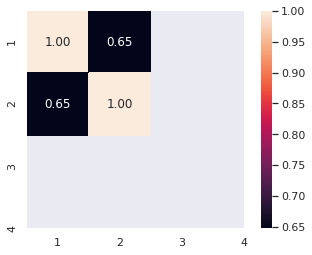

In [48]:
seaborn.heatmap(kappa_scores, annot=True, square=True, fmt=".2f", xticklabels=["1", "2", "3", "4"], yticklabels=["1", "2", "3", "4"])

In [49]:
from itertools import combinations
import numpy as np

In [50]:
unique_kappa = list()
for x, y in combinations(experts, 2): 
    unique_kappa.append(cohen_kappa_score(x, y))
np.average(unique_kappa)

0.6476868327402135

In [51]:
def fleiss_kappa(ratings, n):
    '''
    Computes the Fleiss' kappa measure for assessing the reliability of 
    agreement between a fixed number n of raters when assigning categorical
    ratings to a number of items.
    
    Args:
        ratings: a list of (item, category)-ratings
        n: number of raters
        k: number of categories
    Returns:
        the Fleiss' kappa score
    
    See also:
        http://en.wikipedia.org/wiki/Fleiss'_kappa
    '''
    items = set()
    categories = set()
    n_ij = {}
    
    for i, c in ratings:
        items.add(i)
        categories.add(c)
        n_ij[(i,c)] = n_ij.get((i,c), 0) + 1
    
    N = len(items)
    
    p_j = dict(((c, sum(n_ij.get((i, c), 0) for i in items) / (1.0 * n * N)) for c in categories))
    P_i = dict(((i, (sum(n_ij.get((i, c), 0) ** 2 for c in categories) - n) / (n * (n - 1.0))) for i in items))

    P_bar = sum(P_i.values()) / (1.0 * N)
    P_e_bar = sum(value ** 2 for value in p_j.values())
    
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    
    return kappa

In [52]:
fleiss_kappa_array = list()
for e in list(zip(*experts)): 
    for i in e: 
        fleiss_kappa_array.append((1, i))

In [53]:
fleiss_kappa(fleiss_kappa_array, 4)

-0.33333333333333326

In [54]:
ratings = [(1, 'yes')] * 10 + [(1, 'no')] * 0  + \
[(2, 'yes')] * 8  + [(2, 'no')] * 2  + \
[(3, 'yes')] * 9  + [(3, 'no')] * 1  + \
[(4, 'yes')] * 0  + [(4, 'no')] * 10 + \
[(5, 'yes')] * 7  + [(5, 'no')] * 3
ratings

[(1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'no'),
 (2, 'no'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'no'),
 (5, 'no'),
 (5, 'no')]

In [55]:
x = np.array(experts).T
fleiss_kappa(x)

TypeError: fleiss_kappa() missing 1 required positional argument: 'n'

In [ ]:
ensemble = results.pop()
for r in results: 
    print(r["modality"], fisher_exact([[ensemble["correct"], r["correct"]], [ensemble["incorrect"], r["incorrect"]]]))

In [ ]:
results

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')